# Earthquake damage classification

## 19 September 2017, Mw7.1 Puebla Earthquake, Mexico 🇲🇽

## 0: Preliminaries

### Import python libraries 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import folium
import rasterio
import rasterio.mask
import rasterstats as rs
import seaborn as sns
from shapely.geometry import Point
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
starttime = time()

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Set the default coordinate reference system

In [2]:
dst_crs = "EPSG:4326"

### Indicate paths to input files

In [3]:
event_name = "M7.1 Puebla Earthquake, Mexico"
dpm_raw_file = "DPM/DPM2_S1_MexicoCity_20170920_raw.tif"
dpm_clipped_file = "DPM/DPM2_S1_MexicoCity_20170920_ShakeMapMask.tif"
# building_footprints_file = "Buildings/Buildings.geojson"
damage_labels_file = "DamageLabels/Danos.gpkg"
shakemap_url = "https://earthquake.usgs.gov/product/shakemap/us2000ar20/atlas/1594399976203/download/"
shakemap_json = shakemap_url + "cont_mmi.json" # Contours
shakemap_zip = shakemap_url + "shape.zip" # Polygons

## 1: Demarcate affected area

### Draw an empty map centered on the event¶

In [4]:
lat = +18.550
lon = -98.489

bound_n = lat + 3
bound_e = lon + 3
bound_s = lat - 3
bound_w = lon - 3

m = folium.Map(
    location=[lat, lon], 
    zoom_start=7,
    tiles='Stamen Terrain')

folium.CircleMarker(
    location=[lat, lon],
    radius=5,
    tooltip="Epicenter",
    popup=event_name,
    color="IndianRed",
    fill_color="LightCoral",
    fill=True
).add_to(m)

m

### Draw ShakeMap contours for MMI ≥ V

In [5]:
style_function = lambda x: {
    'color': x["properties"]["color"],
    'weight': x["properties"]["weight"] if x["properties"]["value"] >= 5 else 0
}
tooltip = folium.features.GeoJsonTooltip(fields=["value"])

folium.GeoJson(
    shakemap_json,
    name="ShakeMap Contours",
    style_function=style_function,
    tooltip=tooltip
).add_to(m)

folium.TileLayer('OpenStreetMap').add_to(m)
folium.LayerControl().add_to(m)

m

### Save the MMI V contour as a vector layer

In [6]:
shakemap_gdf = gpd.read_file(shakemap_json)
shakemapV_gdf = shakemap_gdf[shakemap_gdf.value==5]
shakemapV_gdf.to_file("ShakeMap/MMI_V_Contours.gpkg", driver="GPKG")
shakemapV_gdf.convex_hull.to_file("ShakeMap/MMI_V_Envelope.gpkg", driver="GPKG")

## 2: Load DPM tiles and mask to built areas within MMI≥V

### Read the DPM raster and mask it using the MMI V contour

In [7]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

with fiona.open("ShakeMap/MMI_V_Envelope.gpkg", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(dpm_raw_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(dpm_clipped_file, "w", **out_meta) as dest:
    dest.write(out_image)

### Explore the distribution of the clipped DPM pixel values by plotting a histogram

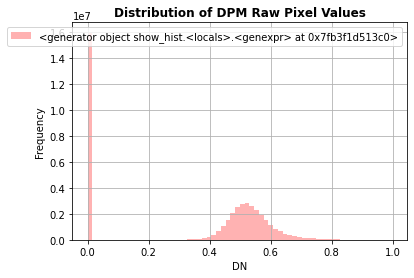

In [8]:
from rasterio.plot import show_hist
dpm_src = rasterio.open(dpm_raw_file)
show_hist(
    dpm_src, bins=64, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Distribution of DPM Raw Pixel Values")

## 3: Load and plot the building inventory files

### Load the building inventory file for Budhanilkantha 

In [ ]:
# bldgs_gdf = gpd.read_file(building_footprints_file)

### Inspect the building inventory file

In [ ]:
# bldgs_gdf.head()

### Drop unnecessary columns

In [ ]:
# bldgs_gdf.drop(columns=["fid", "ObjectType", "PROMJENA"], inplace=True)

## 4: Join the damage labels to the building inventory

### Load the damage labels ("ground truth" / "test labels")

In [12]:
dmg_labels_gdf = gpd.read_file(damage_labels_file)
dmg_labels_gdf.set_index("Immuebla", inplace=True)

# Limit dataset to CDMX as building attributes are 
# not available for Puebla and Mexico states
dmg_labels_gdf = dmg_labels_gdf.loc[dmg_labels_gdf.Zona == "17M"]

### Inspect the damage labels layer contents

In [13]:
dmg_labels_gdf.head()

,Zona,Edificio,Uso,Calle,Calle2,Colonia,Delegación/Colonia,Año estimado de construcción,Número de pisos:,Sistema estructural,...,Periodo estimado del suelo (Ts),amax Estructura,amax Suelo,Cociente Te/Ts,Daño,Daño en Estructuras,Observaciones,Agravante de los daños,MM,geometry
Immuebla,,,,,,,,,,,,,,,,,,,,,
17M|COY_127,17M,Edificio,Edificio de departamentos,Av. Cafetales 1819,Calz. Taxqueña y Cerro San Antonio,Campestre Churubusco,Coyoacán,1964.0,5,Marcos de concreto con muros de mampostería,...,1.679248,88.67672,238.0075,0.285842,Menores,Grietas en acabados y elementos no estructurales,Agrietamiento por cortante de un muro de la pl...,Irregularidad en planta,4970,"POLYGON ((-99.11361 19.30128, -99.11364 19.301..."
17M|COY_69,17M,Casa,Edificio de departamentos,Cda. Francisco I. Madero 86,Ignacio Zaragoza y Bugambilias,Viejo Ejido de Santa Úrsula Coapa,Coyoacán,1991.0,4,Muros de mampostería confinada,...,0.689696,145.38220,232.7418,0.458173,Menores,Grietas en acabados y elementos no estructurales,Pequeñas Grietas en viga,Ninguno apreciable,4980,"POLYGON ((-99.14357 19.30151, -99.14363 19.301..."
17M|COY_05,17M,Edificio,Edificio de departamentos,Rancho de los Arcos 32,Calz del Hueso y Rancho Vista Hermosa,Girasoles,Coyoacán,1984.0,6,Columnas y losa plana de concreto,...,1.166782,141.59800,617.8574,0.649019,Colapso total,Colapso de la planta baja o de toda la estructura,Colapso total de la estructura.,Irregularidad en planta,4920,"POLYGON ((-99.12294 19.30465, -99.12294 19.304..."
17M|COY_128,17M,Plaza,Comercio,Calz. Del Hueso 480,Rancho Vista Hermosa y Calzada del Hueso,Girasoles II,Coyoacán,1980.0,2,Marcos de concreto,...,1.127257,141.59800,318.7860,0.249928,Colapso parcial,Colapso de pisos superiores,"Colapso de una esquina del local, daños en otr...",Efecto de esquina\nIrregularidad en planta,4920,"POLYGON ((-99.12367 19.30424, -99.12371 19.303..."
17M|COY_93,17M,Edificio,Edificio de departamentos,Canal de Miramontes 3040,E. Pallares & Potillo y América,Barrio San Lucas,Coyoacán,1976.0,7,Marcos de concreto con muros de mampostería,...,1.126042,141.59800,530.1363,0.548634,Graves,"Grietas grandes en muros, trabes o columnas",Agrietamiento por cortante en muros de mampost...,Irregularidad en planta\nEfecto de columna corta,4920,"POLYGON ((-99.12400 19.30472, -99.12402 19.304..."


In [14]:
dmg_labels_gdf = dmg_labels_gdf[["Año estimado de construcción", "Número de pisos:", "Sistema estructural", "Periodo estimado del suelo (Ts)", "Daño", "geometry"]]

In [15]:
# Clean up field names
dmg_labels_gdf.rename(
    columns={
    "Año estimado de construcción": "CONSTR_YEAR", 
    "Número de pisos:": "NUM_FLOORS", 
    "Periodo estimado del suelo (Ts)": "SOIL_PERIOD", 
    "Sistema estructural": "CONSTR_TYPE", 
    "Daño": "DAMAGE_GRADE",
    }, 
    inplace=True)

# Inspect contents of the revised files
dmg_labels_gdf.head()

,CONSTR_YEAR,NUM_FLOORS,CONSTR_TYPE,SOIL_PERIOD,DAMAGE_GRADE,geometry
Immuebla,,,,,,
17M|COY_127,1964.0,5,Marcos de concreto con muros de mampostería,1.679248,Menores,"POLYGON ((-99.11361 19.30128, -99.11364 19.301..."
17M|COY_69,1991.0,4,Muros de mampostería confinada,0.689696,Menores,"POLYGON ((-99.14357 19.30151, -99.14363 19.301..."
17M|COY_05,1984.0,6,Columnas y losa plana de concreto,1.166782,Colapso total,"POLYGON ((-99.12294 19.30465, -99.12294 19.304..."
17M|COY_128,1980.0,2,Marcos de concreto,1.127257,Colapso parcial,"POLYGON ((-99.12367 19.30424, -99.12371 19.303..."
17M|COY_93,1976.0,7,Marcos de concreto con muros de mampostería,1.126042,Graves,"POLYGON ((-99.12400 19.30472, -99.12402 19.304..."


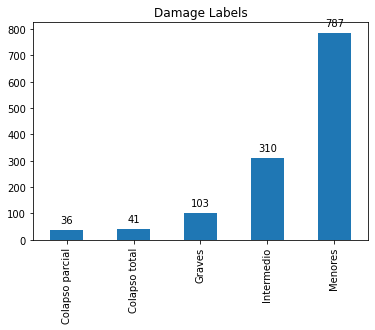

In [16]:
# Inspect the damage grade labels column
ax = (dmg_labels_gdf.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Damage Labels"
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Explanation of damage labels
The damage labels are based on the EMS-98 scale. 
Data source: National Society of Earthquake Technology - Nepal (NSET) and Budhanilkantha Municipality, Kathmandu District

![EMS-98 Damage Grades](https://emergency.copernicus.eu/mapping/sites/default/files/images/DamageAssessement_classification.png)

### Relabel the damage grade labels column with English names

In [17]:
dmg_labels_gdf.replace(
    to_replace={
        "DAMAGE_GRADE":{
            "Menores": "1",
            "Intermedio": "2",
            "Graves": "3",
            "Colapso parcial": "4", 
            "Colapso total": "5"}},
    inplace=True)

# Group similar construction types to reduce the number of classes
dmg_labels_gdf.replace(
    to_replace={
        "CONSTR_TYPE":{
            "Marcos de concreto con muros de mampostería": "Reinforced concrete",
            "Muros de mampostería confinada": "Confined masonry",
            "Columnas y losa plana de concreto": "Reinforced concrete",
            "Marcos de concreto": "Reinforced concrete",
            "Marcos de acero": "Steel frame",
            "Mampostería histórica": "Unreinforced masonry",
            "Muros de mampostería de adobe": "Adobe",
            "Muros de mampostería no confinada": "Unreinforced masonry",
            "Marcos de columnas de concreto y trabes de acero": "Reinforced concrete",
            "Marcos de concreto con muros de concreto": "Reinforced concrete",
            "Marcos de concreto y contravientos de acero": "Reinforced concrete",
            "Estructura metálica": "Other",
            "Marcos y muros de concreto": "Reinforced concrete",
            "Pavimento asfáltico": "Other",
            "Columnas y trabes presforzadas de concreto": "Reinforced concrete",
            "Concreto reforzado": "Reinforced concrete",
            "Columnas y losas planas de concreto": "Reinforced concrete",
            "Mixta": "Other",
            "NA": "Other",}},
    inplace=True)

# Inspect the damage grades database
dmg_labels_gdf.head()

,CONSTR_YEAR,NUM_FLOORS,CONSTR_TYPE,SOIL_PERIOD,DAMAGE_GRADE,geometry
Immuebla,,,,,,
17M|COY_127,1964.0,5,Reinforced concrete,1.679248,1,"POLYGON ((-99.11361 19.30128, -99.11364 19.301..."
17M|COY_69,1991.0,4,Confined masonry,0.689696,1,"POLYGON ((-99.14357 19.30151, -99.14363 19.301..."
17M|COY_05,1984.0,6,Reinforced concrete,1.166782,5,"POLYGON ((-99.12294 19.30465, -99.12294 19.304..."
17M|COY_128,1980.0,2,Reinforced concrete,1.127257,4,"POLYGON ((-99.12367 19.30424, -99.12371 19.303..."
17M|COY_93,1976.0,7,Reinforced concrete,1.126042,3,"POLYGON ((-99.12400 19.30472, -99.12402 19.304..."


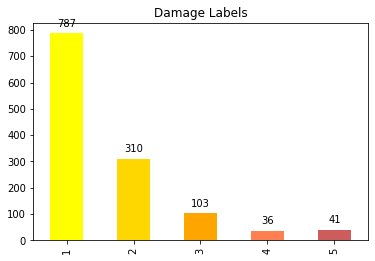

In [18]:
ax = (dmg_labels_gdf.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Damage Labels",
          color=["Yellow", "Gold", "Orange", "Coral", "IndianRed"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

#### Note: This is an imbalanced dataset
The number of samples in Damage Grade "1" is roughly one order of magnitude larger than the number of samples in Damage Grades "4" and "5". Most machine learning multiclass classification algorithms assume that all classes have roughly similar numbers of examples.

To circumvent this issue, one potential route is to modify the training set to have similar numbers of examples in each category, for instance by oversampling training examples from the classes with fewer examples.

Another route is to modify the classification algorithm by changing the way learning is performed, preferably biasing more towards those classes that have fewer examples in the training dataset. This is generally called cost-sensitive learning.

In [19]:
# Inspect the coordinate reference system used by the damage database
dmg_labels_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
# Reproject the damage dataset to the project coordinate reference system
dmg_labels_gdf = dmg_labels_gdf.to_crs(dst_crs)

### Join the damage labels to the building inventory

In [21]:
# Building footprints available from OSM for CDMX do not
# have information about number of stories and year
# of construction that is available in the damage dataset
# We focus this example only on damaged buildings
input_gdf = dmg_labels_gdf

## 5. Join ShakeMap intensity to building inventory

### Join ShakeMap value to the building inventory

In [22]:
# Build url for the ShakeMap polygons shapefile and perform a spatial join
tic = time()
shakemap_shp = f"zip+{shakemap_zip}!mi.shp"
shakemap_gdf = gpd.read_file(shakemap_shp)
inputs_gdf = gpd.sjoin(input_gdf, shakemap_gdf, how="left", op="within")
print(f"Spatial join completed in {time() - tic:.0f}s")

Spatial join completed in 8s


In [23]:
# Drop unneeded columns and rename the remaining ones
inputs_gdf.drop(columns=["index_right", "AREA", "PERIMETER", "PGAPOL_", "PGAPOL_ID", "GRID_CODE"], inplace=True)
inputs_gdf.rename(columns={"Area": "AREA", "layer": "BLDG_TYPE", "PARAMVALUE": "MMI"}, inplace=True)

In [24]:
# Create both string and numeric versions of the shaking intensity vector
inputs_strings = inputs_gdf.astype({"MMI": str, "DAMAGE_GRADE":str})
inputs_numeric = inputs_gdf.astype({"MMI": float, "DAMAGE_GRADE":int})

In [25]:
# Inspect the joined dataset
inputs_numeric.head()

,CONSTR_YEAR,NUM_FLOORS,CONSTR_TYPE,SOIL_PERIOD,DAMAGE_GRADE,geometry,MMI
Immuebla,,,,,,,
17M|COY_127,1964.0,5,Reinforced concrete,1.679248,1,"POLYGON ((-99.11361 19.30128, -99.11364 19.301...",7.2
17M|COY_69,1991.0,4,Confined masonry,0.689696,1,"POLYGON ((-99.14357 19.30151, -99.14363 19.301...",6.8
17M|COY_05,1984.0,6,Reinforced concrete,1.166782,5,"POLYGON ((-99.12294 19.30465, -99.12294 19.304...",7.0
17M|COY_128,1980.0,2,Reinforced concrete,1.127257,4,"POLYGON ((-99.12367 19.30424, -99.12371 19.303...",7.0
17M|COY_93,1976.0,7,Reinforced concrete,1.126042,3,"POLYGON ((-99.12400 19.30472, -99.12402 19.304...",7.0


/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


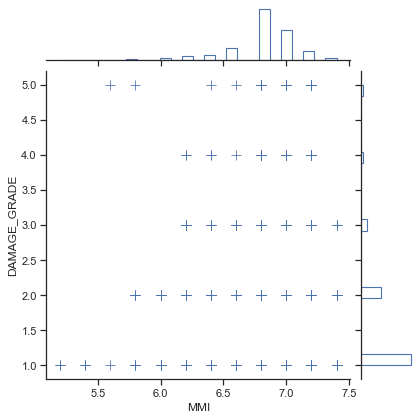

In [26]:
sns.set_theme(style="ticks")
sns.jointplot(
    data=inputs_numeric, 
    x="MMI", y="DAMAGE_GRADE", 
    marker="+", s=100, 
    marginal_kws=dict(bins=25, fill=False),
)

## 6: Join DPM values to the input dataset

### Find the maximum DPM value falling within each buffered building polygon

In [27]:
# This step can take several minutes, depending on the sizes
# of the building inventory + damage database and the DPM raster
tic = time()
with rasterio.open(dpm_clipped_file) as dpm_src:
    dpm_data = dpm_src.read(1, masked=True)
    dpm_meta = dpm_src.profile
    
inputs_list = rs.zonal_stats(
    inputs_numeric,
    dpm_data,
    nodata=-999,
    affine=dpm_meta['transform'],
    geojson_out=True,
    copy_properties=True,
    stats="max")

print(f"Zonal stats query completed in {time() - tic:.0f}s")

# View object type
type(inputs_list)

Zonal stats query completed in 2s


list

### Create dataframe with input variable values and labels

In [28]:
inputs_gdf = gpd.GeoDataFrame.from_features(inputs_list)
inputs_gdf.rename(columns={"max": "DPM_MAX"}, inplace=True)

inputs_gdf.head()

,geometry,CONSTR_TYPE,CONSTR_YEAR,DAMAGE_GRADE,MMI,NUM_FLOORS,SOIL_PERIOD,DPM_MAX
0,"POLYGON ((-99.11361 19.30128, -99.11364 19.301...",Reinforced concrete,1964.0,1,7.2,5,1.679248,0.650247
1,"POLYGON ((-99.14357 19.30151, -99.14363 19.301...",Confined masonry,1991.0,1,6.8,4,0.689696,NaN
2,"POLYGON ((-99.12294 19.30465, -99.12294 19.304...",Reinforced concrete,1984.0,5,7.0,6,1.166782,0.552528
3,"POLYGON ((-99.12367 19.30424, -99.12371 19.303...",Reinforced concrete,1980.0,4,7.0,2,1.127257,0.747877
4,"POLYGON ((-99.12400 19.30472, -99.12402 19.304...",Reinforced concrete,1976.0,3,7.0,7,1.126042,0.785846


1277

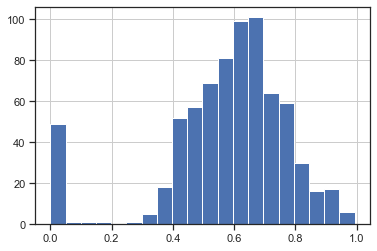

In [29]:
# Plot a histogram of the joined DPM values
# This ignores NaN values, i.e., those buildings for which no DPM value was assigned
dpm_hist = inputs_gdf.DPM_MAX.hist(bins=20)
len(inputs_gdf)

727

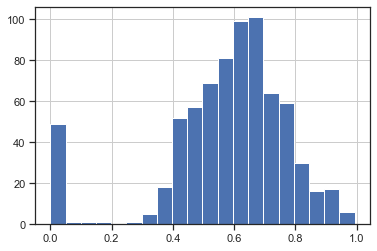

In [30]:
# Drop buildings with no DPM value, as the DPM does
# not cover the entirety of the damage dataset
inputs_gdf.dropna(subset=["DPM_MAX"], inplace=True)
dpm_hist = inputs_gdf.DPM_MAX.hist(bins=20)
len(inputs_gdf)

## 7: Extract and explore the training features and training labels

### Extract the training labels and values as vectors

In [31]:
inputs_gdf["CONSTR_YEAR"] = inputs_gdf.CONSTR_YEAR.replace({0: 1980}) # Modal construction year
inputs_gdf["AGE"] = 2017 - inputs_gdf.CONSTR_YEAR
inputs_gdf["AGE"] = inputs_gdf.AGE.clip(upper=90) # Clip age at 90 to avoid extreme outliers

<AxesSubplot:>

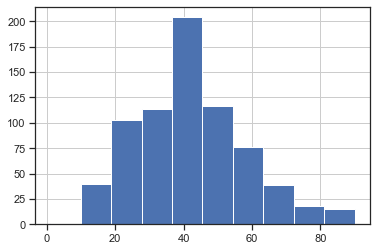

In [32]:
# Plot histogram of the ages of the buildings
inputs_gdf.AGE.hist(bins=10)

<AxesSubplot:>

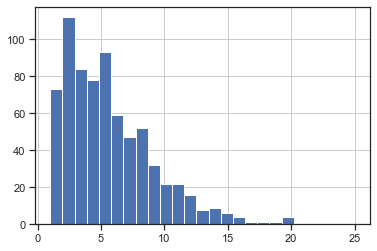

In [33]:
# Plot histogram of the number of floors
inputs_gdf.NUM_FLOORS.hist(bins=25, range=(1, 25))

In [34]:
# Convert the only categorical field, ie, the construction type
# into a numerical field, where the order matters – we apply
# an opinionated ranking of the construction types 
# from most vulnerable (class 1 = Adobe), 
# to least vulnerable (class 6 = Steel frame)
inputs_gdf.replace(
    to_replace={
        "CONSTR_TYPE":{
            "Adobe": 1,
            "Unreinforced masonry": 2,
            "Other": 3,
            "Confined masonry": 4,
            "Reinforced concrete": 5,
            "Steel frame": 6,}},
    inplace=True)

## 7: Extract and explore the training features and training labels

### Extract the training labels and values as vectors

In [35]:
train_values = inputs_gdf[["CONSTR_TYPE", "AGE", "NUM_FLOORS", "SOIL_PERIOD", "MMI", "DPM_MAX"]]
train_labels = inputs_gdf[["DAMAGE_GRADE"]]

<AxesSubplot:>

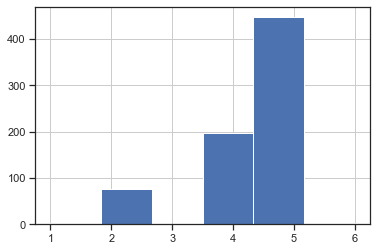

In [36]:
# Plot histogram of the construction type
inputs_gdf.CONSTR_TYPE.hist(bins=6)

In [37]:
train_values.dtypes

CONSTR_TYPE      int64
AGE            float64
NUM_FLOORS       int64
SOIL_PERIOD    float64
MMI            float64
DPM_MAX        float64
dtype: object

In [38]:
train_labels.dtypes

DAMAGE_GRADE    int64
dtype: object

### Explore the training data

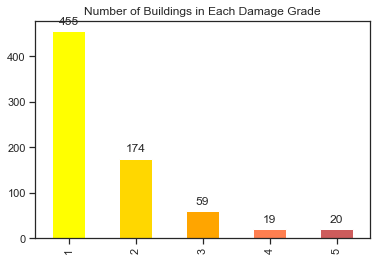

In [39]:
ax = (train_labels.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Number of Buildings in Each Damage Grade",
          color=["Yellow", "Gold", "Orange", "Coral", "IndianRed"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Select subset of features to use for training

In [40]:
selected_features = ["CONSTR_TYPE", "AGE", "NUM_FLOORS", "SOIL_PERIOD", "MMI", "DPM_MAX"]
train_values_subset = train_values[selected_features]

### Explore the relationships between the numeric features and labels

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/si

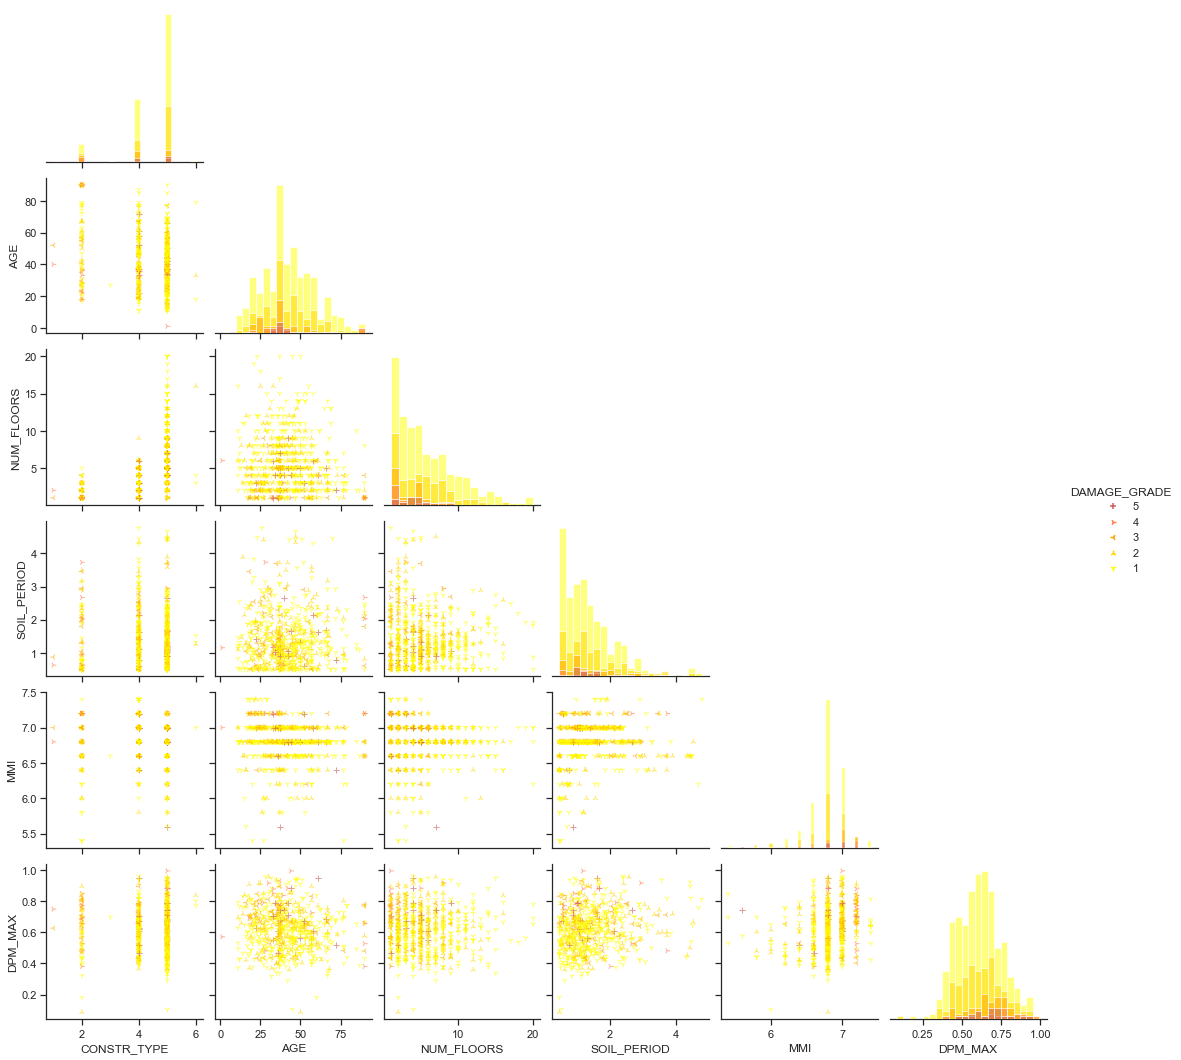

In [41]:
sns.set_theme(style="ticks")
train_values_subset_plot = train_values_subset.replace(0, np.nan)
sns.pairplot(
    train_values_subset_plot.join(train_labels),
    hue="DAMAGE_GRADE",
    hue_order=[5, 4, 3, 2, 1],
    palette={1:"Yellow", 2:"Gold", 3:"Orange", 4:"Coral", 5:"IndianRed"},
    markers=["1", "2", "3", "4", "+"],
    kind="scatter",
    diag_kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
    grid_kws={'diag_sharey':False},
)
plt.savefig("Figures/PairPlot_DS5.png")

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('2').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('2').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('2').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/si

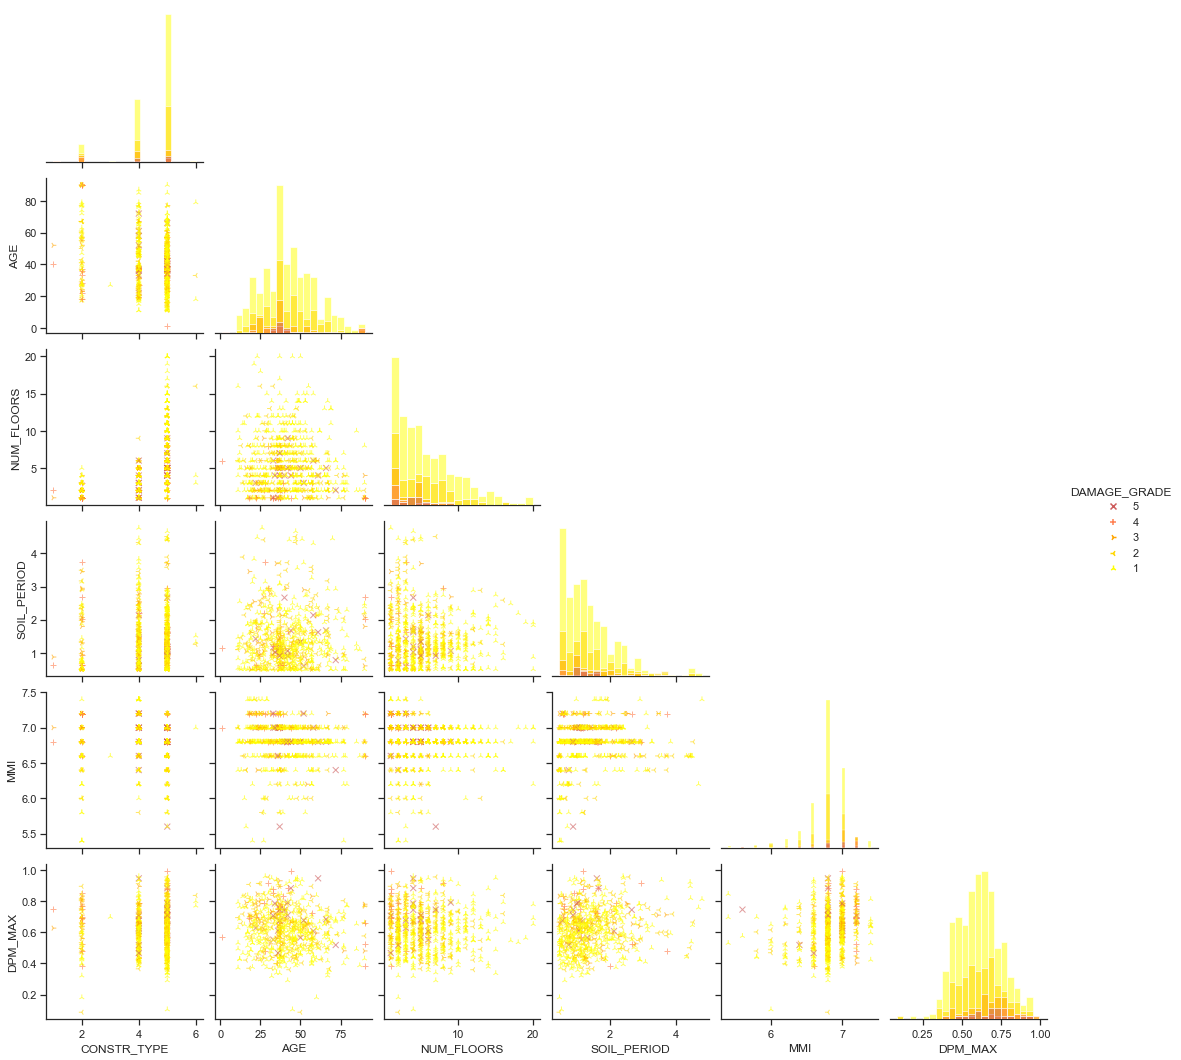

In [42]:
# Ignore Damage Grade 0 for the plots
sns.pairplot(
    train_values_subset_plot.join(train_labels).replace(0, np.nan),
    hue="DAMAGE_GRADE",
    hue_order=[5, 4, 3, 2, 1],
    palette={1:"Yellow", 2:"Gold", 3:"Orange", 4:"Coral", 5:"IndianRed"},
    markers=["2", "3", "4", "+", "x"],
    kind="scatter",
    diag_kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
    grid_kws={'diag_sharey':False},
)
plt.savefig("Figures/PairPlot_DS5.png")

## 8: Build the ML model(s)

### Import modules for the machine learning training component

In [43]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# for unbalanced datasets
from sklearn.utils.class_weight import compute_sample_weight

# for splitting the data into training and test sets
from sklearn.model_selection import train_test_split

# the model(s)
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# for combining the preprocess with model training
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

### Split dataset into training and test subsets

When performing a (supervised) machine learning experiment, it is common to hold out part of the available data as a test set `X_test, y_test`. The best parameters can be determined by grid search techniques.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(train_values_subset, train_labels, train_size=0.70, test_size=0.30, random_state=40)

In [45]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# for unbalanced datasets
from sklearn.utils.class_weight import compute_sample_weight

# for splitting the data into training and test sets
from sklearn.model_selection import train_test_split

# the model(s)
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# for combining the preprocess with model training
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

In [46]:
# n_categorical_features = (X_train.dtypes == 'object').sum()
n_categorical_features = 0
n_numerical_features = ((X_train.dtypes == 'float') | (X_train.dtypes == 'int')).sum()
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of training features: {X_train.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of training samples: 508
Number of training features: 6
Number of categorical features: 0
Number of numerical features: 6


We will create a HistGradientBoostingRegressor estimator that natively handles categorical features. We let the estimator know which features are categorical.

First, we create an ordinal pipeline that will treat categorical features as if they were ordered quantities, i.e. the categories will be encoded as 0, 1, 2, etc.

In [47]:
ordinal_encoder = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),
     make_column_selector(dtype_include='object')),
    remainder='passthrough')

In [48]:
# The ordinal encoder will first output the categorical features, and then the
# continuous (passed-through) features
categorical_mask = ([True] * n_categorical_features + [False] * n_numerical_features)

In [49]:
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

### Use a Histogram Gradient Boosting Classifier

In [50]:
pipe = make_pipeline(ordinal_encoder, HistGradientBoostingClassifier())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb3a9f7f100>)])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

### Train a HistGradientBoostingClassifier model with scikit-learn defaults for all parameters

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [51]:
tic = time()
gs = pipe
gs.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb3a9f7f100>)])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

In [52]:
print(f"Model fit completed in {time() - tic:.0f}s")

Model fit completed in 2s


### Evaluate the model prediction performance on the _training set_

In [53]:
# Evaluation metrics
# from sklearn.metrics import roc_curve # restricted to the binary classification case
# from sklearn.metrics import plot_precision_recall_curve # restricted to the binary classification case
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

#### Compute the F1 score, also known as balanced F-score or F-measure for the _training_ set

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

`F1 = 2 * (precision * recall) / (precision + recall)`

In our multi-class case, this is the average of the F1 score of each class with weighting depending on the average parameter.

In [54]:
# Calculate metrics globally by counting the total true positives, 
# false negatives and false positives.
in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.8651994497936726

In [55]:
# Calculate metrics for each label, and find their average weighted 
# the number of true instances for each label. This alters ‘macro’ to 
# account for label imbalance; it can result in an F-score that is not 
# between precision and recall.
f1_score(train_labels, in_sample_preds, average='weighted')

0.8638095822238763

In [56]:
# Calculate metrics for each label, and find their unweighted mean. 
# This does not take label imbalance into account.
f1_score(train_labels, in_sample_preds, average='macro')

0.8471947487129716

#### Print balanced accuracy score for predictions on the _training_ set

The balanced_accuracy_score function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. It is the macro-average of recall scores per class or, equivalently, raw accuracy where each sample is weighted according to the inverse prevalence of its true class. For balanced datasets, the score is equal to accuracy.

In [57]:
balanced_accuracy_score(train_labels, in_sample_preds)

0.813642813142644

#### Print classification report for predictions on the _training_ set
The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [58]:
target_names = ["Slight Damage", "Intermediate Damage", "Heavy Damage", "Partial Collapse", "Total Collapse"]
print(classification_report(train_labels, in_sample_preds, target_names=target_names))

                     precision    recall  f1-score   support

      Slight Damage       0.89      0.93      0.91       455
Intermediate Damage       0.78      0.75      0.77       174
       Heavy Damage       0.88      0.75      0.81        59
   Partial Collapse       0.94      0.84      0.89        19
     Total Collapse       0.94      0.80      0.86        20

           accuracy                           0.87       727
          macro avg       0.89      0.81      0.85       727
       weighted avg       0.86      0.87      0.86       727



#### Display the confusion matrix for the predictions on the _training_ set

In [59]:
confusion_matrix(train_labels, in_sample_preds)

array([[422,  30,   3,   0,   0],
       [ 39, 131,   3,   0,   1],
       [ 11,   3,  44,   1,   0],
       [  1,   2,   0,  16,   0],
       [  3,   1,   0,   0,  16]])

#### Plot confusion matrix with absolute, non-normalized values

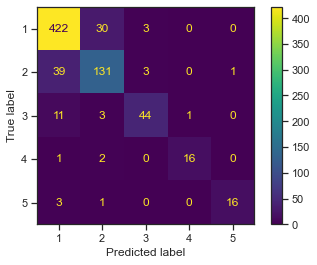

In [60]:
plot_confusion_matrix(
    gs, train_values_subset, train_labels,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

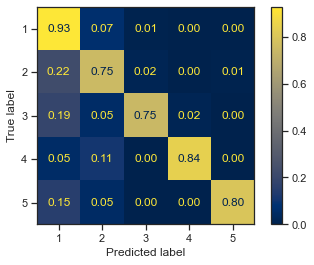

In [61]:
plot_confusion_matrix(
    gs, train_values_subset, train_labels,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

### Partial Dependence and Individual Conditional Expectation

In [62]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

Plot generated in 8s


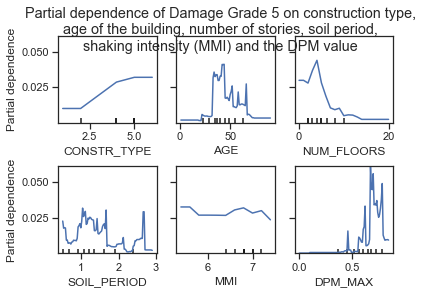

In [63]:
tic = time()
numeric_features = ["CONSTR_TYPE", "AGE", "NUM_FLOORS", "SOIL_PERIOD", "MMI", "DPM_MAX"]
categorical_features = []
display = plot_partial_dependence(
    gs, X_train, numeric_features, target=5
)
print(f"Plot generated in {time() - tic:.0f}s")
display.figure_.suptitle(
    'Partial dependence of Damage Grade 5 on construction type,\n'
    'age of the building, number of stories, soil period,\n'
    'shaking intensity (MMI) and the DPM value'
)
display.figure_.subplots_adjust(hspace=0.5)

### Feature importance based on feature permutation

In [64]:
from sklearn.inspection import permutation_importance

tic = time()
result = permutation_importance(
    gs, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
print(f"Computed relative feature importances in {time() - tic:.0f}s")

importances = pd.Series(result.importances_mean, index=numeric_features)

Computed relative feature importances in 3s


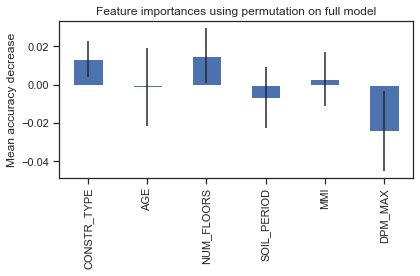

In [65]:
fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## 9: Make predictions on the test set and evaluate the model performance

### Use the trained ML model to make predictions on the test set

In [66]:
y_pred = gs.predict(X_test)

### Evaluate the model prediction performance on the _test_ set

#### Display the confusion matrix for the predictions on the _test_ set

In [67]:
confusion_matrix(y_test, y_pred)

array([[109,  30,   3,   0,   0],
       [ 39,   8,   3,   0,   1],
       [ 11,   3,   3,   1,   0],
       [  1,   2,   0,   1,   0],
       [  3,   1,   0,   0,   0]])

#### Plot confusion matrix with absolute, non-normalized values

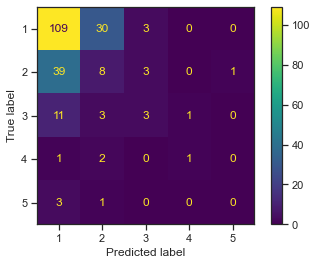

In [68]:
plot_confusion_matrix(
    gs, X_test, y_test,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

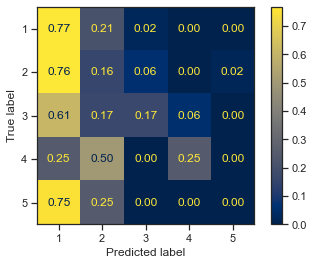

In [69]:
plot_confusion_matrix(
    gs, X_test, y_test,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Print classification report for the predictions on the _test_ set

In [70]:
target_names = ["Slight Damage", "Intermediate Damage", "Heavy Damage", "Partial Collapse", "Total Collapse"]
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

      Slight Damage       0.67      0.77      0.71       142
Intermediate Damage       0.18      0.16      0.17        51
       Heavy Damage       0.33      0.17      0.22        18
   Partial Collapse       0.50      0.25      0.33         4
     Total Collapse       0.00      0.00      0.00         4

           accuracy                           0.55       219
          macro avg       0.34      0.27      0.29       219
       weighted avg       0.51      0.55      0.53       219



#### Print balanced accuracy score for the predictions on the _test_ set

In [71]:
balanced_accuracy_score(y_test, y_pred)

0.26822700911350456

## 10: Try binary classification

### Compress the damage grades into 0 and 1

In [72]:
# Assign buildings with no DPM value to a value of DPM=0
inputs_gdf["DAMAGE_GRADE_BINARY"] = inputs_gdf.DAMAGE_GRADE.apply(lambda x: 0 if x<=2 else 1)

### Extract the training features and training labels

In [73]:
train_values = inputs_gdf[["CONSTR_TYPE", "AGE", "NUM_FLOORS", "SOIL_PERIOD", "MMI", "DPM_MAX"]]
train_labels = inputs_gdf[["DAMAGE_GRADE_BINARY"]]

In [74]:
train_values.dtypes

CONSTR_TYPE      int64
AGE            float64
NUM_FLOORS       int64
SOIL_PERIOD    float64
MMI            float64
DPM_MAX        float64
dtype: object

In [75]:
train_labels.dtypes

DAMAGE_GRADE_BINARY    int64
dtype: object

### Explore the training data

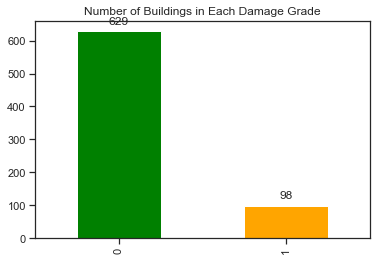

In [76]:
ax = (train_labels.DAMAGE_GRADE_BINARY
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Number of Buildings in Each Damage Grade",
          color=["Green", "Orange"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Select subset of features to use for training

In [77]:
selected_features = ["CONSTR_TYPE", "AGE", "NUM_FLOORS", "SOIL_PERIOD", "MMI", "DPM_MAX"]
train_values_subset = train_values[selected_features]

### Explore the relationships between the numeric features and labels

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/si

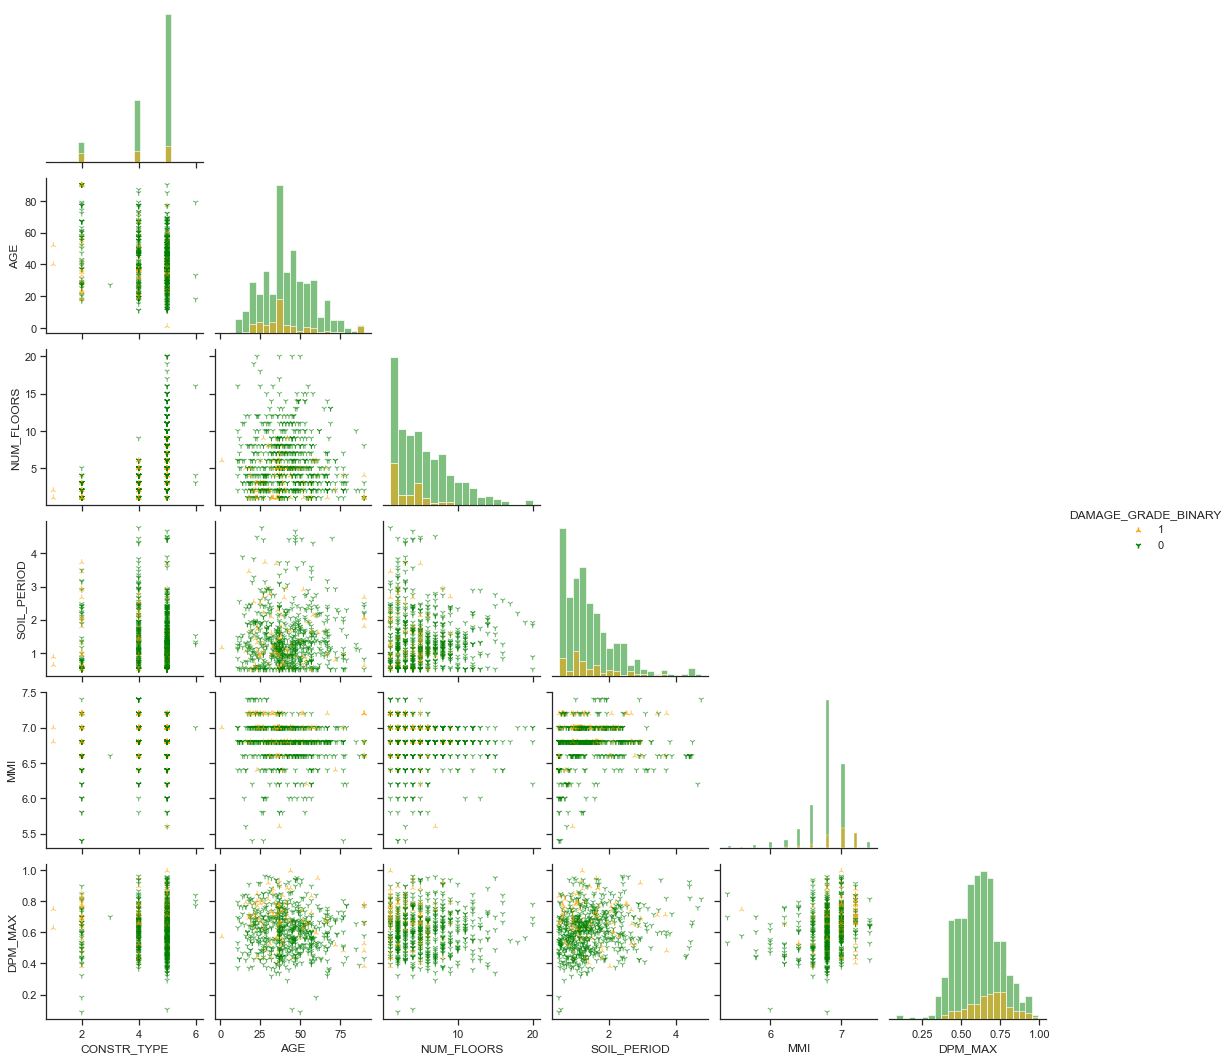

In [78]:
sns.set_theme(style="ticks")
train_values_subset_plot = train_values_subset.replace(0, np.nan)
sns.pairplot(
    train_values_subset_plot.join(train_labels),
    hue="DAMAGE_GRADE_BINARY",
    hue_order=[1, 0],
    palette={0:"Green", 1:"Orange"},
    markers=["1", "2"],
    kind="scatter",
    diag_kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
    grid_kws={'diag_sharey':False},
)

### Split dataset into training and test subsets

When performing a (supervised) machine learning experiment, it is common to hold out part of the available data as a test set `X_test, y_test`. The best parameters can be determined by grid search techniques.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(train_values_subset, train_labels, train_size=0.70, test_size=0.30, random_state=40)

In [80]:
ordinal_encoder = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),
     make_column_selector(dtype_include='object')),
    remainder='passthrough')

In [81]:
# The ordinal encoder will first output the categorical features, and then the
# continuous (passed-through) features
categorical_mask = ([True] * n_categorical_features + [False] * n_numerical_features)

In [82]:
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

### Use a Histogram Gradient Boosting Classifier

In [83]:
pipe = make_pipeline(ordinal_encoder, HistGradientBoostingClassifier())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb3a8e87bb0>)])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

### Train a HistGradientBoostingClassifier model with scikit-learn defaults for all parameters

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [84]:
gs_binary = pipe
gs_binary.fit(X_train, y_train.values.ravel(), histgradientboostingclassifier__sample_weight=sample_weight)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb3a8e87bb0>)])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

### Evaluate the model prediction performance on the _training set_

In [85]:
in_sample_preds = gs_binary.predict(train_values_subset)

#### Plot confusion matrix with absolute, non-normalized values

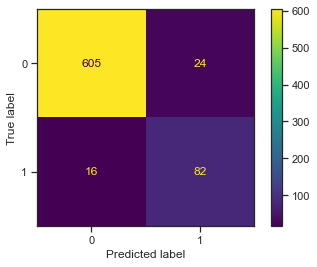

In [86]:
plot_confusion_matrix(
    gs_binary, train_values_subset, train_labels,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

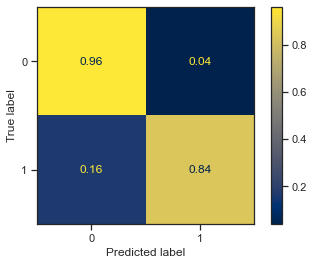

In [87]:
plot_confusion_matrix(
    gs_binary, train_values_subset, train_labels,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

### Use the trained model to make predictions on the test set

In [88]:
y_pred = gs_binary.predict(X_test)

#### Display the confusion matrix for the predictions on the test set

In [89]:
confusion_matrix(y_test, y_pred)

array([[172,  21],
       [ 16,  10]])

#### Plot confusion matrix with absolute, non-normalized values

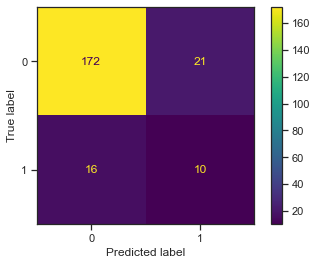

In [90]:
plot_confusion_matrix(
    gs_binary, X_test, y_test,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

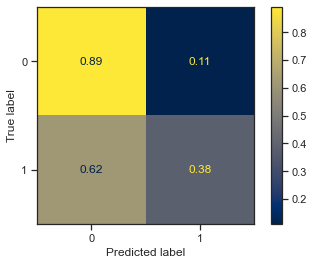

In [91]:
plot_confusion_matrix(
    gs_binary, X_test, y_test,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Print classification report for the predictions on the _test_ set

In [92]:
target_names = ["No Damage", "Damage"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No Damage       0.91      0.89      0.90       193
      Damage       0.32      0.38      0.35        26

    accuracy                           0.83       219
   macro avg       0.62      0.64      0.63       219
weighted avg       0.84      0.83      0.84       219



#### Print balanced accuracy score for the predictions on the _test_ set

In [93]:
balanced_accuracy_score(y_test, y_pred)

0.6379035472299721

In [94]:
print(f"Analysis completed in {time() - starttime:.0f}s")

Analysis completed in 60s
